1. Create a figure (either in python, in a vector-based drawing program like inkscape or illustrator, or as a solidworks rendering) of your system kinematics.

![](https://drive.google.com/uc?export=view&id=1Z0t8McPsNTXCOzi8-_knKtP2BPVten1L)

<h0><center>**Figure 1a: Sarrus Mechanism Kinematics Model**</center></h0>

| Length | Measurement (inches) |
| --- | --- |
| L0 | 1.00 |
| L1 | 1.00 |
| L2 | 2.00 |
| L3 | 1.00 |
| L4 | 1.00 |
| L5 | 2.00 |

<h0><center>**Table 1a**: Kinematics Model Lengths</center></h0>

2. Make the device in paper or cardboard. You need an up-to-date model if it has changed from your individual assignments. The paper model should dimensionally match your code.

A prototype of our system was made using cardstock and the dimsensions from table 1a. Note that the blue cardstock represents our systems electronics hosuing. The team also created a CAD model to further explain the systems motion.

![](https://drive.google.com/uc?export=view&id=1vF3FDDpPDOoug_63z4D0QH-Sv8FplckD)

<h0><center>**Figure 2a**: Cardstock Prototype</center></h0>

![](https://drive.google.com/uc?export=view&id=1lDRbgeCE0FwXcunwHq8IgW-OqHHbCh5X)

<h0><center>**Figure 2b**: CAD Model</center></h0>

3. Using a pynamics-based script, develop a kinematic model for your device.

Show plots inline and ensures that pynamics is installed.

In [1]:
!pip install pypoly2tri idealab_tools foldable_robotics pynamics

In [2]:
%matplotlib inline

Import all required packages.

In [3]:
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.output import Output,PointsOutput
import pynamics.integration
import sympy
import numpy
import matplotlib.pyplot as plt
plt.ion()
from math import pi
import scipy.optimize
import math as m

Create a pynamics system where the mechanism is located.

In [4]:
system = System()
pynamics.set_system(__name__,system)

Declare all length constants based on table 1a.

In [5]:
#This block of code declares and store constants in SI units
l0 = Constant(1,'l0',system) #defines the lengths (in inches) of each frame (1:1 ratio of paper model)
l1 = Constant(1,'l1',system) 
l2 = Constant(2,'l2',system)
l3 = Constant(1,'l3',system)
l4 = Constant(1,'l4',system)
l5 = Constant(2,'l5',system)

Create the differentiable state variables, cooresponding to the joint angles.

In [6]:
#This block of code creates dynamic state variables for the angles shown in our kinematics model
q0,q0_d,q0_dd = Differentiable('q0',system) #angle between N and A frames
q1,q1_d,q1_dd = Differentiable('q1',system) #angle between A and B frames
q4,q4_d,q4_dd = Differentiable('q4',system) #angle between E and F frames
q5,q5_d,q5_dd = Differentiable('q5',system) #angle between N and F frames

Initial guess for starting positions.

In [7]:
#This block of code sets the initial guess for the mechanisms starting position (in radians) and velocity (in m/s)
initialvalues = {}
initialvalues[q0] = 155*pi/180  #optimal angle is 135 but change to 155 to show the code solving successfully
initialvalues[q0_d] = 0*pi/180
initialvalues[q1] = -90*pi/180  #optimal angle is -90
initialvalues[q1_d] = 0*pi/180
initialvalues[q4] = 90*pi/180   #optimal angle is 90
initialvalues[q4_d] = 0*pi/180
initialvalues[q5] = 45*pi/180   #optimal angle is 45
initialvalues[q5_d] = 0*pi/180

Retrieve state variables in the order they are stored in the system.

In [8]:
#This block of code orders the initial values in a list in such a way that the integrator can use it in the same order that it expects the variables to be supplied
statevariables = system.get_state_variables()
ini0 = [initialvalues[item] for item in statevariables]

Create the main reference frames, with one cooresponding to each rigid link.

In [9]:
#This block of code initializes frames
N = Frame('N')
A = Frame('A')
B = Frame('B')
E = Frame('E')
F = Frame('F')

Declare N as the Newtonian (fixed) frame.

In [10]:
#This block of code sets N frame as the newtonian frame (see kinematic diagram from above)
system.set_newtonian(N) 

Rotate frames about their z-axes so they align with the correct rigid link.

In [11]:
#This block of code shows frame rotation in the Z direction
A.rotate_fixed_axis_directed(N,[0,0,1],q0,system)  #the A frame rotates about the N frame in the Z direction (0,0,1) by q0 degrees
B.rotate_fixed_axis_directed(A,[0,0,1],q1,system)  #the B frame rotates about the A frame in the Z direction (0,0,1) by q1 degrees
F.rotate_fixed_axis_directed(N,[0,0,1],q5,system)  #the F frame rotates about the N frame in the Z direction (0,0,1) by q5 degrees
E.rotate_fixed_axis_directed(F,[0,0,1],q4,system)  #the E frame rotates about the F frame in the Z direction (0,0,1) by q4 degrees

Define vectors for each of the joint locations. 

In [12]:
#This block of code defines the points needed to create the mechanism 
pNA = 0*N.x + 0*N.y    #pNA (point NA) position is 0 units in the direction of N reference frame's x direction (0*N.x) and y direction (0*N.y)
pAB = pNA + l0*A.x     #pAB position is pNA's position plus l0 units in the direction of ref frame A's x direction 
pBE = pAB + l1*B.x     #pBE position is pAB's position plus l1 units in the direction of ref frame B's x direction
pNF = l5*N.x + 0*N.y   #pNF position l5 units in the direction of ref frame N's x direction and 0 units in N's y direction
pFE = pNF + l4*F.x     #pFE position is pNF's position plus l4 units in the direction of ref frame F's x direction
pEB = pFE + l3*E.x     #pEB position is pFE's position plus l3 units in the direction of ref frame E's x direction

points = [pNA,pAB,pBE,pEB,pFE,pNF]     #list of points used for plotting

Create all the vector equation constraints.

In [13]:
#This block of code defines the closed loop kinematics (vectors) of the sarrus mechanism.
#Constraint 1:
eq_vector = pEB - pBE   #vector from pEB to pBE
#Constraint 2:
eq_vector1 = pBE - pNA  #vector from pBE to pNA

Convert the vector constraints into scalar equations that can be solved.

In [14]:
#This block of code defines the systems constraints based on the vectors listed above
eq = []

eq.append(((eq_vector).dot(eq_vector))-l2**2)  # (eq_vector) . (eq_vector) = l2**2 -> dot product of a vector with itself gives square of it's length
eq.append(((eq_vector).dot(N.x))-l2)           # (eq_vector) . (N.x) = l2 -> dot product of a vector with the unit vector gives the length of the vector
eq.append((eq_vector1).dot(N.x))               # (eq_vector1) . (N.x) = 0 -> dot product of vectors perpendicular to each other gives 0

eq_d=[(system.derivative(item)) for item in eq]
eq_dd=[(system.derivative(item)) for item in eq_d]

Identify independent and dependent variables.

In [15]:
#This block of code defines the dependent and independent values
qi = [q0]
qd = [q1,q4,q5] #number of items in qd should equal the number of constraints above

For dependent variables, create an initial guess and create a copy of symbolic constants dictionary and add the initial value of qi to it.

In [16]:
#This block of code recalls and stores link lengths or constants declared earlier
constants = system.constant_values.copy() 
defined = dict([(item,initialvalues[item]) for item in qi])
constants.update(defined)

Substitute constants in equation.

In [17]:
eq = [item.subs(constants) for item in eq]
print(eq)

[-2*(-sin(q4)*sin(q5) + cos(q4)*cos(q5))*(-0.422618261740699*sin(q1) - 0.90630778703665*cos(q1)) - 2*(sin(q4)*cos(q5) + sin(q5)*cos(q4))*(-0.90630778703665*sin(q1) + 0.422618261740699*cos(q1)) - (-0.90630778703665*sin(q1) + 0.422618261740699*cos(q1))*sin(q5) - (-0.422618261740699*sin(q1) - 0.90630778703665*cos(q1))*cos(q5) - (-0.90630778703665*sin(q5) - 0.422618261740699*cos(q5))*sin(q1) - (0.422618261740699*sin(q5) - 0.90630778703665*cos(q5))*cos(q1) - (0.422618261740699*sin(q5) - 0.90630778703665*cos(q5))*cos(q4) - (0.90630778703665*sin(q5) + 0.422618261740699*cos(q5))*sin(q4) + 1.6904730469628*sin(q1) - 4.90630778703665*sin(q4)*sin(q5) - 0.422618261740699*sin(q4)*cos(q5) - 0.422618261740699*sin(q5)*cos(q4) - 0.845236523481399*sin(q5) + 5.6252311481466*cos(q1) + 4.90630778703665*cos(q4)*cos(q5) + 2*cos(q4) + 5.8126155740733*cos(q5) + 7.6252311481466, 0.422618261740699*sin(q1) - sin(q4)*sin(q5) + 0.90630778703665*cos(q1) + cos(q4)*cos(q5) + cos(q5) + 0.90630778703665, -0.4226182617406

Convert to numpy array and sum the error.

In [18]:
#This block of code converts to numpy array and sums the error
error = (numpy.array(eq)**2).sum()

4. Select or Solve for a valid initial condition that represents the system in the middle of a typical gait, when it is both moving and when forces are being applied to it.

Convert to a function that scipy can use. Sympy has a “labmdify” function that evaluates an expression, but scipy needs a slightly different format.

In [19]:
#This block of code converts to a function that scipy can use 
#Sympy has a "labmdify" function that evaluates an expression
#Scipy uses a different format
f = sympy.lambdify(qd,error)

def function(args):
    return f(*args)

Take the derivative of the equations to linearize with regard to the velocity variables.

In [20]:
#This block of code solves for the desired mechanism (orange) givin the initial guesses (blue)
#An incorrect initial guess was used on purpose to visualize that the system was solved correctly
guess = [initialvalues[item] for item in qd]
result = scipy.optimize.minimize(function,guess)

if result.fun>1e-3:
    raise(Exception("out of tolerance"))
print("Tolerance:", result.fun)

ini = []
for item in system.get_state_variables():
    if item in qd:
        ini.append(result.x[qd.index(item)])
    else:
        ini.append(initialvalues[item])

Tolerance: 7.359495135748648e-12


Code solved for the desired mechanism (orange) given the initial guesses (blue). Purposely input a wrong initial guess for one angle so that it is easy to visualize that the system solved correctly.

5. Plot the system in this position.

Create a plot of the optimized points defining the mechanism.

2021-03-30 17:41:37,840 - pynamics.output - INFO - calculating outputs
2021-03-30 17:41:37,843 - pynamics.output - INFO - done calculating outputs


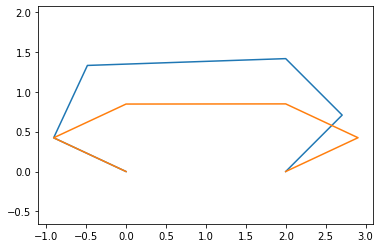

In [21]:
points = PointsOutput(points, constant_values=system.constant_values)
points.calc(numpy.array([ini0,ini]))
points.plot_time()

Solving for the internal Jacobian by converting the constrain equations into vectors (resulting in independent and dependent equations). Next, we take the derivative of those constraint equation vectors and solve for the internal input/output Jacobian.

In [22]:
#The following blocks of code find the internal jacobian
eq_d = sympy.Matrix(eq_d)            #turn constraint equations into a vector

qi = sympy.Matrix([q0_d])            #turn qi and qd into sympy vectors
qd = sympy.Matrix([q1_d,q4_d,q5_d])

AA = eq_d.jacobian(qi)               #take partial derivative of constraints with respect to independent and dependent variables
AA.simplify()
BB = eq_d.jacobian(qd)
BB.simplify()
J = -BB.inv()*AA                     #solve for internal input/output Jacobian
J.simplify()                         #we can use the simplify function provided by sympy to shorten the expression
J

⎡            ⎛ l₀⋅sin(q₀)      ⎞            ⎤
⎢           -⎜──────────── + l₁⎟            ⎥
⎢            ⎝sin(q₀ + q₁)     ⎠            ⎥
⎢           ─────────────────────           ⎥
⎢                     l₁                    ⎥
⎢                                           ⎥
⎢-l₀⋅(l₃⋅sin(q₄ + q₅) + l₄⋅sin(q₅))⋅sin(q₁) ⎥
⎢───────────────────────────────────────────⎥
⎢         l₃⋅l₄⋅sin(q₄)⋅sin(q₀ + q₁)        ⎥
⎢                                           ⎥
⎢          l₀⋅sin(q₁)⋅sin(q₄ + q₅)          ⎥
⎢          ───────────────────────          ⎥
⎣          l₄⋅sin(q₄)⋅sin(q₀ + q₁)          ⎦

Note: this may take some time to calculate due to the complexity of the system 

6. From your biomechanics-based specifications, define one or more force vector estimates (one for each end effector) that the system should be expected to experience.

**Assumptions:**

*   force of gravity is pulling the system down
*   normal force against walls when sarrus mechanism is contracted
*   frictional force will oppose the force of gravity

The average mass of a razor clam is 0.0462 kg. As a result, the force of gravity on the robot clam will be 0.453 N. Based on prior research we know that the average acceleration of a razor clam is 0.01 m/s^2. We assume that our systesms will be made from cardstock and climb a wooden coefficient of friction will be 0.25. Assuming the sarrus mechanism has a normal force of 0.5 N on the walls, the frictional force of the system will be 2*(0.5*0.25) = 0.25 N. 

**Note:** we multiply by two in order to take into account both sides of the sarrus mechanism making contact with the crevice walls.

7. Calculate the force or torque required at the input to satisfy the end-effector force requirements

Solving for the dependent variables qd:

In [23]:
qd2 = J*qi
qd2

⎡                  ⎛ l₀⋅sin(q₀)      ⎞            ⎤
⎢           -q_0_d⋅⎜──────────── + l₁⎟            ⎥
⎢                  ⎝sin(q₀ + q₁)     ⎠            ⎥
⎢           ───────────────────────────           ⎥
⎢                        l₁                       ⎥
⎢                                                 ⎥
⎢-l₀⋅q_0_d⋅(l₃⋅sin(q₄ + q₅) + l₄⋅sin(q₅))⋅sin(q₁) ⎥
⎢─────────────────────────────────────────────────⎥
⎢            l₃⋅l₄⋅sin(q₄)⋅sin(q₀ + q₁)           ⎥
⎢                                                 ⎥
⎢          l₀⋅q_0_d⋅sin(q₁)⋅sin(q₄ + q₅)          ⎥
⎢          ─────────────────────────────          ⎥
⎣             l₄⋅sin(q₄)⋅sin(q₀ + q₁)             ⎦

Now we can create a substitution dictionary to replace all occurrances of dependent variables)

In [24]:
subs = dict([(ii,jj) for ii,jj in zip(qd,qd2)])
subs

⎧              ⎛ l₀⋅sin(q₀)      ⎞                                            
⎪       -q_0_d⋅⎜──────────── + l₁⎟                                            
⎨              ⎝sin(q₀ + q₁)     ⎠          -l₀⋅q_0_d⋅(l₃⋅sin(q₄ + q₅) + l₄⋅si
⎪q_1_d: ───────────────────────────, q_4_d: ──────────────────────────────────
⎩                    l₁                                 l₃⋅l₄⋅sin(q₄)⋅sin(q₀ +

                                                     ⎫
                                                     ⎪
n(q₅))⋅sin(q₁)          l₀⋅q_0_d⋅sin(q₁)⋅sin(q₄ + q₅)⎬
───────────────, q_5_d: ─────────────────────────────⎪
 q₁)                       l₄⋅sin(q₄)⋅sin(q₀ + q₁)   ⎭

Then we pick an end-effector

In [25]:
pout = pAB

Solving for vout:

In [26]:
vout = pout.time_derivative()
vout = vout.subs(subs)
vout

l0*q0_d*A.y

Solving for Force and Torque of the system:

In [27]:
#This block of code defines the force at the end-effector based on data from the biomechanics research conducted by the team
F_end = numpy.array([0.5, 0.25, 0]).T #force vector on end effector
F_inp = J.T.dot(F_end)
F_inp

                                                       ⎛ l₀⋅sin(q₀)      ⎞
                                                   0.5⋅⎜──────────── + l₁⎟
  0.25⋅l₀⋅(l₃⋅sin(q₄ + q₅) + l₄⋅sin(q₅))⋅sin(q₁)       ⎝sin(q₀ + q₁)     ⎠
- ────────────────────────────────────────────── - ───────────────────────
            l₃⋅l₄⋅sin(q₄)⋅sin(q₀ + q₁)                        l₁          

In [28]:
#This block of code solves for the max torque at the end-effector 
t_end = J.T*F_end
t_end

array([[-0.5*(l0*sin(q0)/sin(q0 + q1) + l1)/l1,
        -0.25*l0*(l3*sin(q4 + q5) + l4*sin(q5))*sin(q1)/(l3*l4*sin(q4)*sin(q0 + q1)),
        0]], dtype=object)

8. Estimate the velocity of the end-effector in this configuration. Using the Jacobian, calculate the speed required by the input(s) to achieve that output motion.

In [29]:
#This block of code defines the speed at the end-effector based on data from the biomechanics research conducted by the team
v_max = sympy.Matrix([0,20.3,0])
qA_d_max = J.T*v_max
qA_d_max

⎡-20.3⋅l₀⋅(l₃⋅sin(q₄ + q₅) + l₄⋅sin(q₅))⋅sin(q₁) ⎤
⎢────────────────────────────────────────────────⎥
⎣           l₃⋅l₄⋅sin(q₄)⋅sin(q₀ + q₁)           ⎦

9. Finally, using the two estimates about force and speed at the input, compute the required power in this configuration

In [30]:
#This block of code solves for the required power needed to produce the motion
P_max = F_inp*qA_d_max
P_max

⎡                                        ⎛                                    
⎢                                        ⎜                                    
⎢                                        ⎜  0.25⋅l₀⋅(l₃⋅sin(q₄ + q₅) + l₄⋅sin(
⎢-20.3⋅l₀⋅(l₃⋅sin(q₄ + q₅) + l₄⋅sin(q₅))⋅⎜- ──────────────────────────────────
⎢                                        ⎝            l₃⋅l₄⋅sin(q₄)⋅sin(q₀ + q
⎢─────────────────────────────────────────────────────────────────────────────
⎣                                                  l₃⋅l₄⋅sin(q₄)⋅sin(q₀ + q₁) 

                   ⎛ l₀⋅sin(q₀)      ⎞⎞         ⎤
               0.5⋅⎜──────────── + l₁⎟⎟         ⎥
q₅))⋅sin(q₁)       ⎝sin(q₀ + q₁)     ⎠⎟         ⎥
──────────── - ───────────────────────⎟⋅sin(q₁) ⎥
₁)                        l₁          ⎠         ⎥
────────────────────────────────────────────────⎥
                                                ⎦

# Discussion

1. How many degrees of freedom does your device have? How many motors? If the answer is not the same, what determines the state of the remaining degrees of freedom? How did you arrive at that number?

Our mechanism has has only one degree of freedom. The links will be constrained to allow the output to translate in the y direction. We modeled the mechanism with one sarrus link, but our final design will consist of three. In order to achieve a climbing motion, we need to move each sarrus link individually. As a result, we will be moving our mechanism with three motors (one for each sarrus link).

2. If your mechanism has more than one degree of freedom, please describe how those multiple degrees of freedom will work togehter to create a locomotory gait or useful motion. What is your plan for synchonizing, especially if passive energy storage?

Our system has only one degree of freedom in the y direction. When the motor is running, the y distance between links A and B decreases and the x distance between pBC and pEF will increase. As shown in the video above, when the motor is active the sarrus link expands in the x direction making contact with the outer walls of a crevice. The frictional force with the walls will prevent the sarrus link from slipping. The outer most sarrus links are used to lock into the walls of a crevice. The middle sarrus link is used to increase the distance between the two outer sarrus links. As one of the outer sarrus links locks into place, the middle link will expand in the y direction, and the other outer link will lock. As a result, the device can manipulate each of the sarrus links contraction and extension to create a translation in the y direction, similar to that of a razor clam. A motor will control the input of the three sarrus links. A spring will be used to extend the sarrus links and the motor will be used to contract them.

3. How did you estimate your expected end-effector forces?

After revising our concept, our team’s robot kinematics was modeled after the razor clam. We used prior research on the biomechanics of a razor clam to determine speed, forces, etc. The primary difference between the bioinspired animal and the robot is the razor clam burrows into sand while the team’s robot is climbing vertically between two surfaces. The top, or end effector, of the robot would be moving vertically with only gravity as the opposing force. The end effector force can be expressed in the simulation as a function of velocity due to ‘Force = Mass * Acceleration’, whereas acceleration is substituted for given velocity over time.

4. How did you estimate your expected end-effector speeds?

We found the velocity of the end effector through the python simulation shown above. The geometric relationships for angular speed lead us to determine the output velocity at a specific input. We estimated velocity values based on the values we determined from the biomechanics assignment. From this research we found that the razor clam can move upward a distance of 5mm anywhere from 1.6 to 7.5 seconds. We took the average of this speed and used it as a reference. 
